## Set up

In [148]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import fasttext
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## Get data

The data was cleaned and pre-processed already in data_preprocess_eric

In [2]:
df = pd.read_csv('data/merged_pp_df.csv')
df = df.dropna(subset=['stopwords_punct_lemma'])
df.head()

,comment_text,toxic,stopwords_punct_lemma,vector_spacy,pos_tags,pos_tags_str
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,[ 0.57358134 0.40742856 -2.652657 -2.634505...,"[('This', 'DT'), ('is', 'VBZ'), ('so', 'RB'), ...","DT VBZ RB JJ . PRP VBZ IN , FW PRP VBP PRP$ NN..."
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,[ 2.39850569e+00 8.94715786e-02 -3.68755722e+...,"[('Thank', 'NNP'), ('you', 'PRP'), ('!', '.'),...",NNP PRP . . DT MD VB PRP$ NN DT NN JJR JJ . VB...
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,[ 0.9049366 1.0650175 -1.8506068 -0.667853...,"[('This', 'DT'), ('is', 'VBZ'), ('such', 'JJ')...",DT VBZ JJ DT JJ NN NN : VB TO PRP IN VBG PRP I...
3,Is this something I'll be able to install on m...,0,able install site release,[ 2.15365 0.84712 -1.303075 -1.185065...,"[('Is', 'VBZ'), ('this', 'DT'), ('something', ...",VBZ DT NN PRP MD VB JJ TO VB IN PRP$ NN . WRB ...
4,haha you guys are a bunch of losers.,1,haha guy bunch loser,[-1.30565000e+00 -1.20353746e+00 -1.54419506e+...,"[('haha', 'NN'), ('you', 'PRP'), ('guys', 'NNS...",NN PRP NNS VBP DT NN IN NNS .


In [3]:
X = df['stopwords_punct_lemma']
y = df['toxic']

### Create labels fasttext as per convention

In [4]:
df['toxic_label_ft'] = "__label__" + df['toxic'].astype(str)
df.head(3)

,comment_text,toxic,stopwords_punct_lemma,vector_spacy,pos_tags,pos_tags_str,toxic_label_ft
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,[ 0.57358134 0.40742856 -2.652657 -2.634505...,"[('This', 'DT'), ('is', 'VBZ'), ('so', 'RB'), ...","DT VBZ RB JJ . PRP VBZ IN , FW PRP VBP PRP$ NN...",__label__0
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,[ 2.39850569e+00 8.94715786e-02 -3.68755722e+...,"[('Thank', 'NNP'), ('you', 'PRP'), ('!', '.'),...",NNP PRP . . DT MD VB PRP$ NN DT NN JJR JJ . VB...,__label__0
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,[ 0.9049366 1.0650175 -1.8506068 -0.667853...,"[('This', 'DT'), ('is', 'VBZ'), ('such', 'JJ')...",DT VBZ JJ DT JJ NN NN : VB TO PRP IN VBG PRP I...,__label__0


In [5]:
df['toxic_label_comment_text'] = df['toxic_label_ft'] + " " + df['stopwords_punct_lemma']
df.head(3)

,comment_text,toxic,stopwords_punct_lemma,vector_spacy,pos_tags,pos_tags_str,toxic_label_ft,toxic_label_comment_text
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,[ 0.57358134 0.40742856 -2.652657 -2.634505...,"[('This', 'DT'), ('is', 'VBZ'), ('so', 'RB'), ...","DT VBZ RB JJ . PRP VBZ IN , FW PRP VBP PRP$ NN...",__label__0,__label__0 cool like want mother read great idea
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,[ 2.39850569e+00 8.94715786e-02 -3.68755722e+...,"[('Thank', 'NNP'), ('you', 'PRP'), ('!', '.'),...",NNP PRP . . DT MD VB PRP$ NN DT NN JJR JJ . VB...,__label__0,__label__0 thank life lot anxiety inducing let...
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,[ 0.9049366 1.0650175 -1.8506068 -0.667853...,"[('This', 'DT'), ('is', 'VBZ'), ('such', 'JJ')...",DT VBZ JJ DT JJ NN NN : VB TO PRP IN VBG PRP I...,__label__0,__label__0 urgent design problem kudo take imp...


## Split and train for the fast text model

In [6]:
train,test = train_test_split(df,test_size=0.2, random_state=42, stratify=y) 

In [11]:
train.to_csv("data/fasttext_train", columns=["toxic_label_comment_text"], index=False, header=False)
test.to_csv("data/fasttext_test", columns=["toxic_label_comment_text"], index=False, header=False)

In [76]:
model = fasttext.train_supervised(input="data/fasttext_train", 
                                  lr=0.5, 
                                  epoch=15, 
                                  wordNgrams=2, 
                                  t=0.0001)
model.test("data/fasttext_test")

Read 38M words
Number of words:  446476
Number of labels: 2
Progress: 100.0% words/sec/thread: 3243835 lr:  0.000000 avg.loss:  0.056990 ETA:   0h 0m 0s


(242400, 0.9425536303630363, 0.9425536303630363)

### Get vectors

In [17]:
def clean_text(text):
    """
    Function to remove newline characters from text.
    """
    # Replace newline characters with spaces
    cleaned_text = text.replace('\n', ' ')
    return cleaned_text

In [18]:
tqdm.pandas()
df['stopwords_punct_lemma'] = df['stopwords_punct_lemma'].progress_apply(clean_text)
df['vector_fast_text'] = df['stopwords_punct_lemma'].progress_apply(lambda text: model.get_sentence_vector(text))

100%|██████████| 1800402/1800402 [00:26<00:00, 67276.44it/s]


In [19]:
df.head(3)

,comment_text,toxic,stopwords_punct_lemma,vector_spacy,pos_tags,pos_tags_str,toxic_label_ft,toxic_label_comment_text,vector_fast_text
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,[ 0.57358134 0.40742856 -2.652657 -2.634505...,"[('This', 'DT'), ('is', 'VBZ'), ('so', 'RB'), ...","DT VBZ RB JJ . PRP VBZ IN , FW PRP VBP PRP$ NN...",__label__0,__label__0 cool like want mother read great idea,"[-0.045399435, 0.07104978, -0.047424514, -0.01..."
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,[ 2.39850569e+00 8.94715786e-02 -3.68755722e+...,"[('Thank', 'NNP'), ('you', 'PRP'), ('!', '.'),...",NNP PRP . . DT MD VB PRP$ NN DT NN JJR JJ . VB...,__label__0,__label__0 thank life lot anxiety inducing let...,"[-0.06339683, 0.09824624, -0.066878095, -0.039..."
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,[ 0.9049366 1.0650175 -1.8506068 -0.667853...,"[('This', 'DT'), ('is', 'VBZ'), ('such', 'JJ')...",DT VBZ JJ DT JJ NN NN : VB TO PRP IN VBG PRP I...,__label__0,__label__0 urgent design problem kudo take imp...,"[-0.059046045, 0.11193881, -0.052347053, -0.04..."


In [20]:
df.drop(["pos_tags","pos_tags_str","toxic_label_ft","toxic_label_comment_text"],axis=1,inplace=True)

In [21]:
df.head(3)

,comment_text,toxic,stopwords_punct_lemma,vector_spacy,vector_fast_text
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,[ 0.57358134 0.40742856 -2.652657 -2.634505...,"[-0.045399435, 0.07104978, -0.047424514, -0.01..."
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,[ 2.39850569e+00 8.94715786e-02 -3.68755722e+...,"[-0.06339683, 0.09824624, -0.066878095, -0.039..."
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,[ 0.9049366 1.0650175 -1.8506068 -0.667853...,"[-0.059046045, 0.11193881, -0.052347053, -0.04..."


In [22]:
df.drop(["vector_spacy"],axis=1,inplace=True)

In [23]:
df.head(3)

,comment_text,toxic,stopwords_punct_lemma,vector_fast_text
0,"This is so cool. It's like, 'would you want yo...",0,cool like want mother read great idea,"[-0.045399435, 0.07104978, -0.047424514, -0.01..."
1,Thank you!! This would make my life a lot less...,0,thank life lot anxiety inducing let way,"[-0.06339683, 0.09824624, -0.066878095, -0.039..."
2,This is such an urgent design problem; kudos t...,0,urgent design problem kudo take impressive,"[-0.059046045, 0.11193881, -0.052347053, -0.04..."


### temporary store the fast text vectors to use them with other models

In [146]:
# only need to run once
#df.to_csv('data/alldata_fast_text_vectors.csv')

## Fast Text with SMOTE and Logistic Regression

In [89]:

# Convert list of vectors into a 2D numpy array
X = np.stack(df['vector_fast_text'].values)
y = df['toxic'].values

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a model (Logistic Regression)
clf = LogisticRegression(max_iter=2500)  # Increasing max_iter for convergence
clf.fit(X_train_smote, y_train_smote)

# Evaluate the model on the original test set
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))




              precision    recall  f1-score   support

           0       0.99      0.94      0.97    331340
           1       0.57      0.89      0.69     28741

    accuracy                           0.94    360081
   macro avg       0.78      0.91      0.83    360081
weighted avg       0.96      0.94      0.94    360081



In [144]:
sentence_vector = model.get_sentence_vector("I love all kind of people, black, gays, muslims, Christians")
sentence_vector_reshaped = np.array(sentence_vector).reshape(1, -1)  # Reshape to 2D array

# Now use this reshaped vector for prediction
prediction = clf.predict(sentence_vector_reshaped)
prediction_proba = clf.predict_proba(sentence_vector_reshaped)

if prediction == 1:
    prediction_text = 'Toxic'
else:
    prediction_text = 'Non-Toxic'

# Output the prediction
print(f'This comment is {prediction_text}')
print(f'The probability of being Non-Toxic is: {prediction_proba[0][0]}')
print(f'The probability of being Toxic is: {prediction_proba[0][1]}')

This comment is Non-Toxic
The probability of being Non-Toxic is: 0.7775231014852543
The probability of being Toxic is: 0.2224768985147457


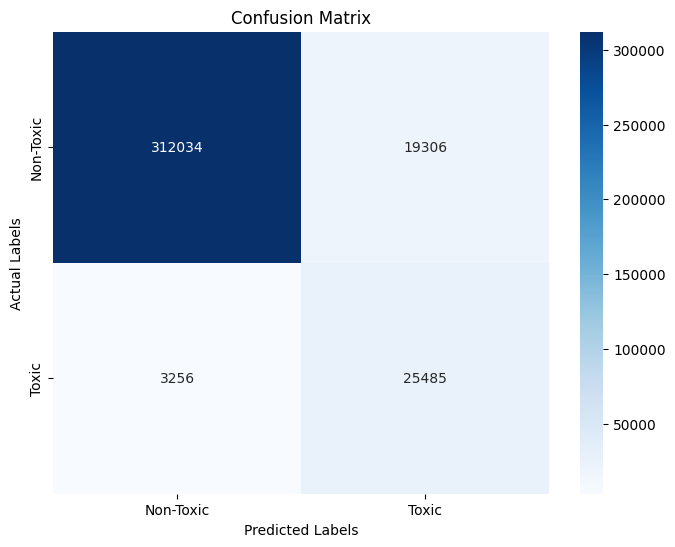

In [149]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()